<a href="https://colab.research.google.com/github/Vladislavjk/ML-Pet-Projects/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [32]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import re

from collections import Counter
from sklearn.metrics import accuracy_score
from nltk.stem.snowball import EnglishStemmer
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud

# Constants

In [2]:
VOCAB_SIZE = 5000

# Loading and processing data

In [3]:
! ls 'drive/MyDrive/data for colab'

 flight_delays_test.csv   'Tabular Playground Series'
 flight_delays_train.csv   tabular-playground-series-feb-2022
'language detection'	  'Tabular Playground Series - Jan 2022'
 nlp-getting-started	   Twitter_Data.csv


In [4]:
df = pd.read_csv('drive/MyDrive/data for colab/Twitter_Data.csv')

In [5]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [6]:
df.category = df.category.map({-1 : 2, 0 : 0, 1 : 1})

In [7]:
df.category.value_counts(normalize=True)

1.0    0.443325
0.0    0.338786
2.0    0.217889
Name: category, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


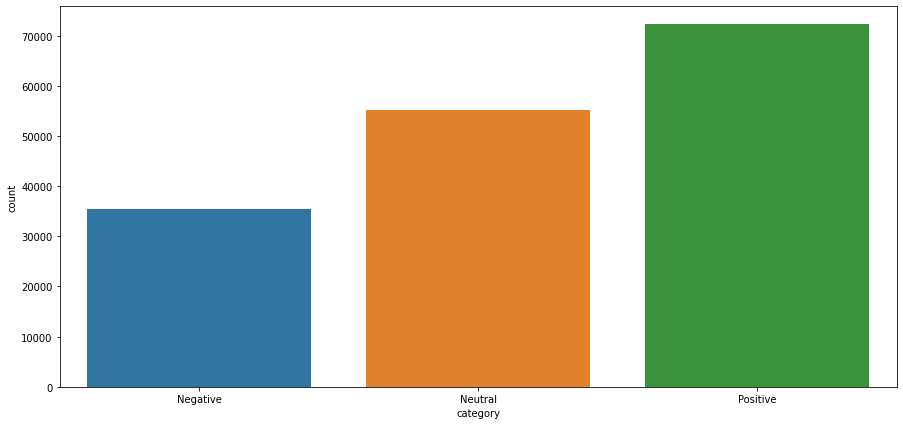

In [8]:
plt.figure(figsize = (15, 7))
sns.countplot(df.category.map({0 : 'Neutral', 1 : 'Positive', 2 : 'Negative'}));

In [9]:
df.isna().mean()

clean_text    0.000025
category      0.000043
dtype: float64

In [10]:
df.dropna(inplace=True)

In [11]:
tweets, y = df.clean_text.values, df.category.values

# Stemmer

In [12]:
stemer = EnglishStemmer()
regex = re.compile('[^a-zA-Z ]')
stem_cache = {}

def get_stem(token):
    stem = stem_cache.get(token, None)
    if stem:
        return stem
    token = regex.sub('', token).lower()
    stem = stemer.stem(token)
    stem_cache[token] = stem
    return stem

# Vocabulary creation

In [13]:
stem_count = Counter()
tokenizer = TweetTokenizer()

def count_unique_tokens_in_tweets(tweets):
    for tweet in tweets:
        tokens = tokenizer.tokenize(tweet)
        for token in tokens:
            stem = get_stem(token)
            stem_count[stem] += 1

count_unique_tokens_in_tweets(tweets)

In [14]:
print("Total unique stems found: ", len(stem_count))

Total unique stems found:  82193


In [15]:
vocab = sorted(stem_count, key=stem_count.get, reverse=True)[:VOCAB_SIZE]
print(vocab[:100])

['modi', 'the', '', 'and', 'for', 'you', 'india', 'that', 'not', 'will', 'this', 'are', 'with', 'have', 'has', 'but', 'all', 'from', 'was', 'his', 'they', 'bjp', 'peopl', 'who', 'what', 'like', 'your', 'congress', 'elect', 'vote', 'can', 'onli', 'now', 'narendra', 'say', 'whi', 'our', 'nation', 'govt', 'it', 'about', 'one', 'year', 'indian', 'time', 'countri', 'dont', 'him', 'just', 'give', 'when', 'their', 'want', 'get', 'how', 'more', 'know', 'rahul', 'make', 'support', 'should', 'did', 'ani', 'govern', 'even', 'against', 'there', 'after', 'then', 'take', 'also', 'come', 'power', 'which', 'work', 'parti', 'out', 'gandhi', 'minist', 'again', 'them', 'polit', 'think', 'need', 'credit', 'leader', 'had', 'see', 'good', 'becaus', 'than', 'other', 'ask', 'space', 'these', 'would', 'been', 'money', 'said', 'hai']


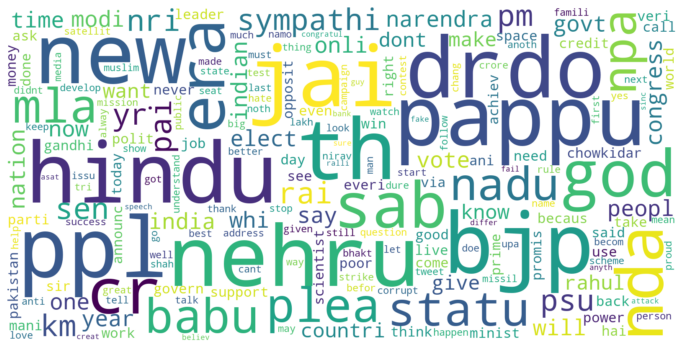

In [16]:
plt.figure(figsize=(12,10))
plt.axis("off")

pos_wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color='white').generate(' '.join(vocab))
plt.imshow(pos_wordcloud, interpolation="bilinear");

In [17]:
idx = 3
print("stem: {}, count: {}"
      .format(vocab[idx], stem_count.get(vocab[idx])))

stem: and, count: 67374


In [18]:
token_2_idx = {vocab[i] : i for i in range(VOCAB_SIZE)}
len(token_2_idx)

5000

In [19]:
token_2_idx['that']

7

In [52]:
def tweet_to_vector(tweet):
  vector = np.zeros(VOCAB_SIZE)
  for token in tokenizer.tokenize(tweet):
      stem = get_stem(token)
      idx = token_2_idx.get(stem, None)
      if idx is not None:
        vector[idx] = 1
  return vector

In [53]:
tweet = tweets[3]
print("tweet: {}".format(tweet))
print("vector: {}".format(tweet_to_vector(tweet)[:10]))
print(vocab[0])

tweet: asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars
vector: [1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
modi


# Converting Tweets to vectors

In [22]:
def tweets_to_vector(tweets):
  X = np.zeros(
    (tweets.shape[0], VOCAB_SIZE))
  for i, tweet in enumerate(tweets):
    for token in tokenizer.tokenize(tweet):
      stem = get_stem(token)
      idx = token_2_idx.get(stem, None)
      if idx is not None:
        X[i, idx] = 1
  return X

In [23]:
X = tweets_to_vector(tweets)

In [24]:
size = int(0.7 * X.shape[0])
X_train, X_test, y_train, y_test = X[:size], X[size:], y[:size], y[size:]

# Building the NN

In [25]:
model = keras.Sequential([
                     keras.layers.Dense(125, activation='relu'),
                     keras.layers.Dense(25, activation='relu'),
                     keras.layers.Dense(3, activation='softmax')
])

In [26]:
# компиляция модели

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics='accuracy')

In [28]:
input_shape = (None, VOCAB_SIZE)
model.build(input_shape)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 125)               625125    
                                                                 
 dense_1 (Dense)             (None, 25)                3150      
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                                 
Total params: 628,353
Trainable params: 628,353
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(X_train, y_train, batch_size=128, epochs=15)

Epoch 1/15
892/892 [==============================] - 13s 14ms/step - loss: 0.4494 - accuracy: 0.8300
Epoch 2/15
892/892 [==============================] - 12s 14ms/step - loss: 0.2732 - accuracy: 0.9027
Epoch 3/15
892/892 [==============================] - 12s 13ms/step - loss: 0.1929 - accuracy: 0.9325
Epoch 4/15
892/892 [==============================] - 12s 13ms/step - loss: 0.1185 - accuracy: 0.9608
Epoch 5/15
892/892 [==============================] - 12s 13ms/step - loss: 0.0690 - accuracy: 0.9785
Epoch 6/15
892/892 [==============================] - 13s 14ms/step - loss: 0.0415 - accuracy: 0.9878
Epoch 7/15
892/892 [==============================] - 12s 14ms/step - loss: 0.0289 - accuracy: 0.9918
Epoch 8/15
892/892 [==============================] - 18s 21ms/step - loss: 0.0236 - accuracy: 0.9932
Epoch 9/15
892/892 [==============================] - 18s 20ms/step - loss: 0.0206 - accuracy: 0.9940
Epoch 10/15
892/892 [==============================] - 12s 13ms/step - loss: 0.014

# Testing

In [33]:
y_pred = [np.argmax(pred) for pred in model.predict(X_test)]
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.8534290564725614


In [87]:
pd.Series(y_pred).value_counts(normalize=True)

1    0.450512
0    0.351639
2    0.197848
dtype: float64

In [88]:
def test_tweet(tweet):
    tweet_vector = tweet_to_vector(tweet).reshape((1, VOCAB_SIZE))
    y_pred = model.predict(tweet_vector)[0]
    print(f'Original tweet: {tweet}')
    print(f'Negative = {y_pred[2]}, Neutral = {y_pred[0]}, Positive = {y_pred[1]}')

In [89]:
def test_tweet_by_id(id):
  return test_tweet(tweets[id])

In [90]:
test_tweet_by_id(120705)

Original tweet: nirav modi denied bail again over pnb fraud case now faces possibility extradition india
Negative = 9.448857667413633e-18, Neutral = 1.0, Positive = 1.0845244702295531e-09


# Real life testing

In [108]:
tweets_for_testing = [
    "i was expelled from university",
    "Russia invaded Ukraine",
    "Does this work?",
    "I'm bad person",
    "Kill me pls",
    "Fuck you",
    "Are you real?",
    "i don't think you are right",
    "i love you",
    "what the hell is wrong with you",
    "i can't help but hate you",
    "i can't hate you"
]
for tweet in tweets_for_testing:
    test_tweet(tweet) 
    print("---------")

Original tweet: i was expelled from university
Negative = 2.2748892547497235e-07, Neutral = 0.9999916553497314, Positive = 8.143060767906718e-06
---------
Original tweet: Russia invaded Ukraine
Negative = 1.674035488008485e-08, Neutral = 0.9999995231628418, Positive = 4.545141223388782e-07
---------
Original tweet: Does this work?
Negative = 2.1184816887398483e-06, Neutral = 0.999983549118042, Positive = 1.4333892067952547e-05
---------
Original tweet: I'm bad person
Negative = 0.9999949932098389, Neutral = 4.672941031458322e-06, Positive = 3.4043006280626287e-07
---------
Original tweet: Kill me pls
Negative = 0.043263282626867294, Neutral = 0.9567108154296875, Positive = 2.5847390134003945e-05
---------
Original tweet: Fuck you
Negative = 0.9979782700538635, Neutral = 0.002021083142608404, Positive = 6.649888746323995e-07
---------
Original tweet: Are you real?
Negative = 1.156904545496218e-06, Neutral = 0.0008148621418513358, Positive = 0.9991839528083801
---------
Original tweet: i